In [1]:
class Node:
    """
    Each node in neural networks will have these attributes and methods
    """
    def __init__(self,inputs=[]):
        """
        if the node is the operator of "ax + b", the inputs will be x node , and the outputs 
        of this is its successors. 
        
        and the value is *ax + b*
        """
        self.inputs=inputs
        self.value=None
        self.outputs=[]
        self.gradients={}
        
        for node in self.inputs:
            node.outputs.append(self)
        
    def forward(self):
        """Forward propogation
        
        compute the output value based on input nodes and store the value 
        into *self.value*
        """
        raise NotImplemented
        
    def backward(self):
        """ Back propogation
        compute the gradient of each input node and store the value 
        into "self.gredients"
        """
        raise NotImplemented

In [2]:
class Input(Node):
    def __init__(self,name=''):
        Node.__init__(self,inputs=[])
        self.name=name
        
    def forward(self,value=None):
        if value is not None:
            self.value = value
    def backward(self):
        self.gradients={}
        
        for n in self.outputs:
            gradient_cost = n.gradients[self]
            self.gradients[self]=gradient_cost
    def __repr__(self):
        return 'Input Node: {}'.format(self.name)

In [3]:
class Linear(Node):
    def __init__(self,nodes,weights,bias):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        Node.__init__(self,inputs=[nodes,weights,bias])
    def forward(self):
        """compute the wx + b using numpy"""
        self.value = np.dot(self.x_node.value,self.w_node.value)+self.b_node.value
        
    def backward(self):
        for n in self.outputs:
            gradient_cost = n.gradients[self]
            self.gradients[self.x_node] = np.dot(gradient_cost , self.w_node.value.T)
            self.gradients[self.w_node] = np.dot(self.x_node.value.T ,gradient_cost)
            self.gradients[self.b_node] = np.sum(gradient_cost*1,axis=0,keepdims=False)

In [4]:
class sigmoid(Node):
    def __init__(self,node):
        Node.__init__(self,inputs=[node])
        self.x_node = node
    def _sigmoid(self,x):
        return 1.0/(1+np.exp(-1*x))
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
    def backward(self):
        y=self.value
        self.partial = y*(1-y)
        for n in self.outputs:
            gradient_cost = n.gradients[self]
            self.gradients[self.x_node]=gradient_cost * self.partial

In [5]:
class MSE(Node):
    def __init__(self,y_true,y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self,inputs=[y_true,y_hat])
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1,1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1,1)
        self.diff = y_true_flatten - y_hat_flatten
        self.value = np.mean(self.diff **2)
    def backward(self):
        n=self.y_hat_node.value.shape[0]
        self.gradients[self.y_true_node] = 2*self.diff/n
        self.gradients[self.y_hat_node] = -2*self.diff/n
        

In [6]:
def toplogical_sort(data_with_value):
    feed_dict=data_with_value
    input_nodes = [n for n in feed_dict.keys()]
    #print(input_nodes)
    G={}
    nodes = [n for n in input_nodes]
    #print(nodes)
    while(len(nodes)>0):
        n=nodes.pop(0)
        if n not in G:
            G[n]={'in':set(),'out':set()}
        for m in n.outputs:
            if m not in G:
                G[m]={'in':set(),'out':set()}
            G[m]['in'].add(n)
            G[n]['out'].add(m)
            nodes.append(m)
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        if isinstance(n, Input):
            n.value = feed_dict[n]
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    #print('S is,,,',S)
    #print('L is ,,,',L)
    #print('G22 is ,,,',G)
    return L

In [7]:
from sklearn.datasets import load_boston
import numpy as np
from sklearn.utils import resample

In [8]:
data = load_boston()

In [9]:
X_=data['data']
y_=data['target']

In [10]:
X_.shape

(506, 13)

In [11]:
X_=(X_-np.mean(X_,axis=0))/np.std(X_,axis=0)

In [12]:
X_

array([[-0.41978194,  0.28482986, -1.2879095 , ..., -1.45900038,
         0.44105193, -1.0755623 ],
       [-0.41733926, -0.48772236, -0.59338101, ..., -0.30309415,
         0.44105193, -0.49243937],
       [-0.41734159, -0.48772236, -0.59338101, ..., -0.30309415,
         0.39642699, -1.2087274 ],
       ...,
       [-0.41344658, -0.48772236,  0.11573841, ...,  1.17646583,
         0.44105193, -0.98304761],
       [-0.40776407, -0.48772236,  0.11573841, ...,  1.17646583,
         0.4032249 , -0.86530163],
       [-0.41500016, -0.48772236,  0.11573841, ...,  1.17646583,
         0.44105193, -0.66905833]])

In [13]:
n_features=X_.shape[1]

In [16]:
X_.shape[0]

506

In [14]:
n_hidden=10

In [17]:
W1_,b1_ = np.random.randn(n_features,n_hidden),np.zeros(n_hidden)

In [18]:
W2_,b2_=np.random.randn(n_hidden,1),np.zeros(1)

In [19]:
X,y=Input(name='X'),Input(name='y')
W1,b1 = Input(name='W1'),Input(name='b1')
W2,b2 = Input(name='W2'),Input(name='b2')

In [22]:
W1.value

In [23]:
y

Input Node: y

In [36]:
linear_output = Linear(X,W1,b1)
sigmoid_output = sigmoid(linear_output)
yhat=Linear(sigmoid_output,W2,b2)
Loss = MSE(y,yhat)

In [37]:
input_node_with_value = {
    X:X_,
    y:y_,
    W1:W1_,
    W2:W2_,
    b1:b1_,
    b2:b2_ 
}

In [38]:
graph=toplogical_sort(input_node_with_value)

In [39]:
graph

[Input Node: W1,
 Input Node: X,
 Input Node: y,
 Input Node: W2,
 Input Node: b1,
 Input Node: b2,

In [40]:
a=graph[-1].value

In [41]:
a

In [42]:
def training_one_batch(topological_sorted_graph):
    # graph 是经过拓扑排序之后的 一个list
    for node in topological_sorted_graph:
        node.forward()
    for node in topological_sorted_graph[::-1]:
        node.backward()

In [43]:
def sgd_update(trainable_nodes, learning_rate):
    for t in trainable_nodes:
        t.value+=-1*learning_rate*t.gradients[t]

In [44]:
def sgd_update(trainable_nodes, learning_rate=1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

In [45]:
losses=[]
epochs=5000
batch_size=64
step_per_epoch = X_.shape[0]
print(X_.shape[0])
print('steps_per_epoch',step_per_epoch)

for i in range(epochs):
    loss=0
    for batch in range(step_per_epoch):
        X_batch,y_batch = resample(X_,y_,n_samples=batch_size)
        X.value=X_batch
        y.value=y_batch
        training_one_batch(graph)
        learning_rate = 1e-3
        sgd_update(trainable_nodes=[W1, W2, b1, b2], learning_rate=learning_rate)
        
        loss += graph[-1].value
    if i % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i+1, loss/step_per_epoch))
        losses.append(loss)
        #print('losses----',losses)

506
steps_per_epoch 506
Epoch: 1, loss = 100.474
Epoch: 101, loss = 6.111
Epoch: 201, loss = 5.212
Epoch: 301, loss = 4.788
Epoch: 401, loss = 4.548
Epoch: 501, loss = 4.182
Epoch: 601, loss = 4.070
Epoch: 701, loss = 4.009
Epoch: 801, loss = 3.874
Epoch: 901, loss = 3.925
Epoch: 1001, loss = 3.823
Epoch: 1101, loss = 3.832
Epoch: 1201, loss = 3.736
Epoch: 1301, loss = 3.741
Epoch: 1401, loss = 3.677
Epoch: 1501, loss = 3.738
Epoch: 1601, loss = 3.575
Epoch: 1701, loss = 3.610
Epoch: 1801, loss = 3.575
Epoch: 1901, loss = 3.506
Epoch: 2001, loss = 3.485
Epoch: 2101, loss = 3.514
Epoch: 2201, loss = 3.516
Epoch: 2301, loss = 3.434
Epoch: 2401, loss = 3.452
Epoch: 2501, loss = 3.436
Epoch: 2601, loss = 3.454
Epoch: 2701, loss = 3.270
Epoch: 2801, loss = 3.222
Epoch: 2901, loss = 3.263
Epoch: 3001, loss = 3.218
Epoch: 3101, loss = 3.242
Epoch: 3201, loss = 3.226
Epoch: 3301, loss = 3.202
Epoch: 3401, loss = 3.140
Epoch: 3501, loss = 3.092
Epoch: 3601, loss = 3.181
Epoch: 3701, loss = 3.11

In [46]:
import matplotlib.pyplot as plt

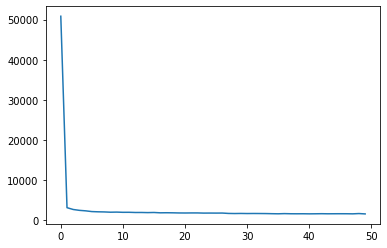

In [47]:
plt.plot(losses)